# CNN Cancer Detection Mini Project

## Project Description
This project looks at a collection of image samples to determine whether or not the sample is benign (label = 0), or cancer (label = 1). The Kaggle competition has a set of training images with labels provided, so I'll build and train my model using this data, and then use my model to predict the labels for competition test image set.

## EDA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

(220025, 2)
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
dtype: int64


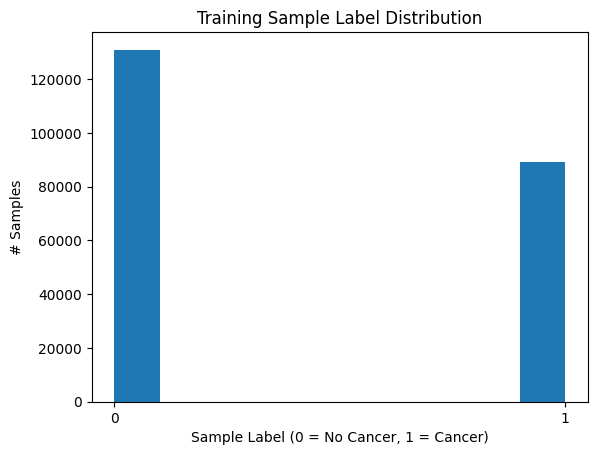

In [2]:
# Load the training labels and look at the label distribution

df_all = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print(df_all.shape)
print(df_all.describe())
print(df_all.head())

# Look at how many samples belong to each label
print(df_all.groupby('label').size())

plt.hist(df_all['label'])
plt.xlabel('Sample Label (0 = No Cancer, 1 = Cancer)')
plt.xticks([0, 1])
plt.ylabel('# Samples')
plt.title('Training Sample Label Distribution')
plt.show()

There are about 220 thousand training images, with about 60% of those being beign and the other 40% being cancerous. I'm going to load the images and append them to the data frame, then display the first 5 images along with their labels to make sure this was done correctly.

In [3]:
# Adding a column to the data frame for the image
# I kept getting kernel errors when attempting to load all of the samples
# So I'm only loading a subset of the samples
# For a more robust model, I'd use all of the samples
df_sample = df_all.head(100000)

df_sample["img"] = df_sample["id"].apply(lambda x: mpimg.imread("/kaggle/input/histopathologic-cancer-detection/train/" + x + ".tif"))

<ipython-input-3-ce7ad6eac57f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample["img"] = df_sample["id"].apply(lambda x: mpimg.imread("/kaggle/input/histopathologic-cancer-detection/train/" + x + ".tif"))


                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                                 img  
0  [[[246, 246, 244], [247, 247, 245], [249, 248,...  
1  [[[251, 247, 246], [253, 248, 245], [243, 238,...  
2  [[[255, 236, 255], [126, 88, 129], [122, 85, 1...  
3  [[[134, 75, 169], [164, 102, 188], [195, 128, ...  
4  [[[93, 23, 47], [147, 88, 120], [64, 19, 62], ...  
Label: 0


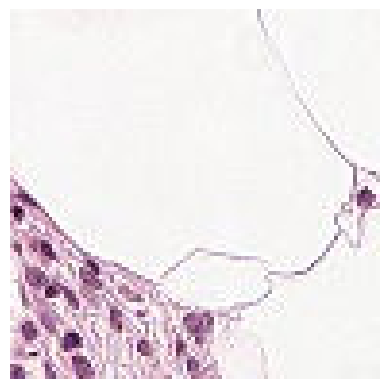

Label: 1


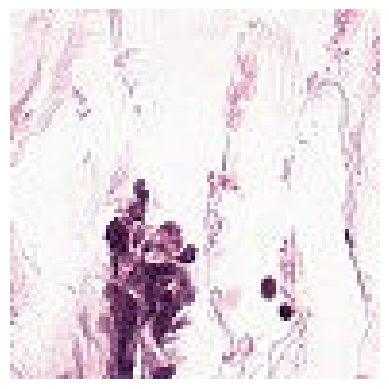

Label: 0


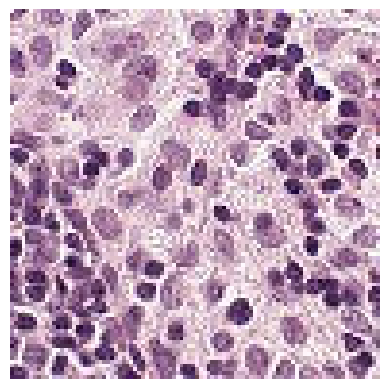

Label: 0


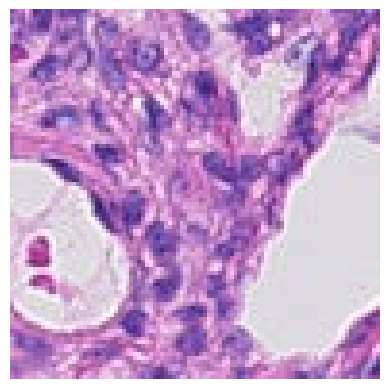

Label: 0


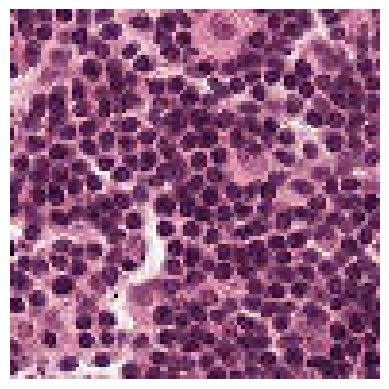

In [4]:
print(df_sample.head())

# Display the first 5 images along with the label
for i in range(5):
    img = df_sample.iloc[i]['img'] 
    label = df_sample.iloc[i]['label']
    
    plt.imshow(img)
    plt.axis('off')

    print(f'Label: {label}')
    plt.show()


## Model Building
All of the images are 96x96, so I don't need to worry about handling images of varying sizes. First I'll split the dataset into training and test sets, then compile and fit the Sequential model. I'll use 3 convolution layers with normalization between the layers. I'll also include a dropout layer to help prevent overfitting.

In [5]:
(df_train, df_test) = train_test_split(df_sample, random_state = 5, test_size = .25)
x_train = np.asarray(df_train["img"])
y_train = np.asarray(df_train["label"])
x_test = np.asarray(df_test["img"])
y_test = np.asarray(df_test["label"])

x_train = np.array([np.array(val) for val in x_train])
x_train = np.expand_dims(x_train, -1)
y_train = keras.utils.to_categorical(y_train, num_classes=2)

x_test = np.array([np.array(val) for val in x_test])
x_test = np.expand_dims(x_test, -1)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(96, 96, 3)),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(.5),
        Dense(2, activation="sigmoid"),
    ]
)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "auc"])

epochs = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test AUC:", score[2])


Epoch 1/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - accuracy: 0.7355 - auc: 0.7545 - loss: 0.9423 - val_accuracy: 0.6749 - val_auc: 0.7638 - val_loss: 0.8780
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1142s 2s/step - accuracy: 0.7980 - auc: 0.8302 - loss: 0.6015 - val_accuracy: 0.6936 - val_auc: 0.7490 - val_loss: 1.0248
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1169s 2s/step - accuracy: 0.8112 - auc: 0.8465 - loss: 0.5607 - val_accuracy: 0.7375 - val_auc: 0.8385 - val_loss: 0.9367
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - accuracy: 0.8323 - auc: 0.8763 - loss: 0.4635 - val_accuracy: 0.7976 - val_auc: 0.8730 - val_loss: 0.5121
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1144s 2s/step - accuracy: 0.8487 - auc: 0.8988 - loss: 0.4078 - val_accuracy: 0.8471 - val_auc: 0.9081 - val_loss: 0.3998
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1163s 2s/step - accuracy: 0.8620 - auc: 0.9135 - loss: 0.3585 - val_accuracy: 0.8452 - val_auc: 0.9134 - val_loss: 0.4153
Epoch 7/10
528/528 ━━━━━━━━━

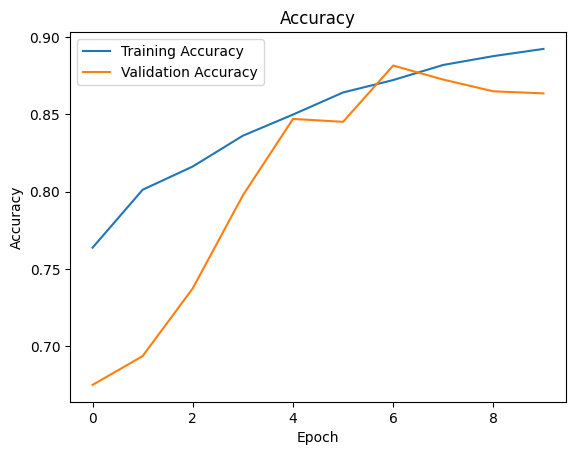

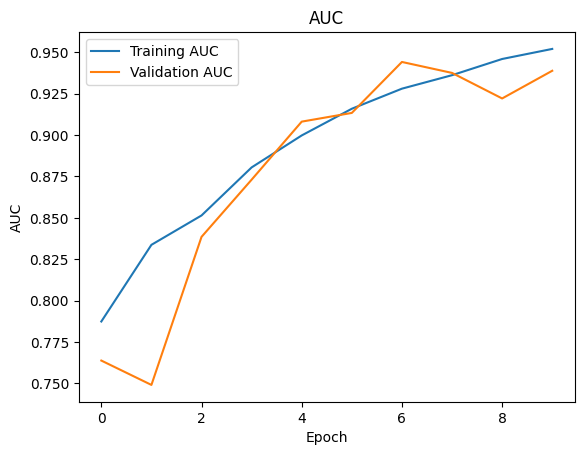

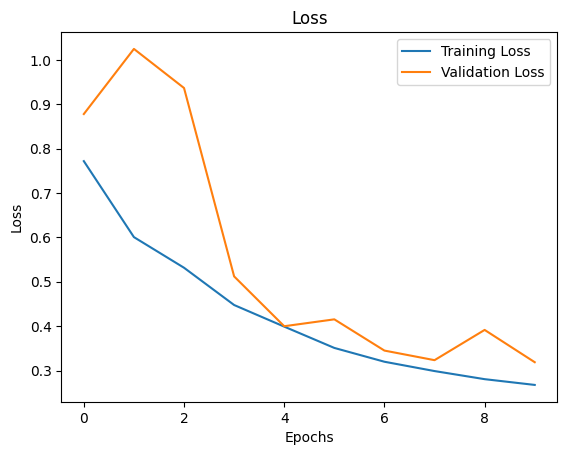

In [13]:
accuracy = epochs.history['accuracy']
val_accuracy = epochs.history['val_accuracy']
auc = epochs.history['auc']
val_auc = epochs.history['val_auc']
loss = epochs.history['loss']
val_loss = epochs.history['val_loss']
epochs_range = range(len(accuracy))

plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(epochs_range, auc, label = 'Training AUC')
plt.plot(epochs_range, val_auc, label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC')
plt.show()

plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Hyperparameter Tuning

It looks like the model still hasn't converged even in later epochs, so I'll try running the model again, but with more epochs and with early stopping so it doesn't continue running past the convergence.

In [14]:
model_es = keras.Sequential(
    [
        keras.Input(shape=(96, 96, 3)),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(.5),
        Dense(2, activation="sigmoid"),
    ]
)
model_es.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "auc"])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

epoch_history_es = model_es.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, callbacks=[early_stopping])

score = model_es.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test AUC:", score[2])

Epoch 1/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.7492 - auc: 0.7873 - loss: 0.8923 - val_accuracy: 0.8027 - val_auc: 0.8642 - val_loss: 0.5915
Epoch 2/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - accuracy: 0.7952 - auc: 0.8468 - loss: 0.6331 - val_accuracy: 0.7955 - val_auc: 0.8531 - val_loss: 0.4807
Epoch 3/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1187s 2s/step - accuracy: 0.8150 - auc: 0.8641 - loss: 0.5417 - val_accuracy: 0.7123 - val_auc: 0.8125 - val_loss: 0.7924
Epoch 4/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1184s 2s/step - accuracy: 0.8241 - auc: 0.8786 - loss: 0.5210 - val_accuracy: 0.7403 - val_auc: 0.8369 - val_loss: 0.5874
Epoch 5/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.8446 - auc: 0.8984 - loss: 0.4419 - val_accuracy: 0.8216 - val_auc: 0.8937 - val_loss: 0.4293
Epoch 6/20
528/528 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - accuracy: 0.8608 - auc: 0.9186 - loss: 0.3665 - val_accuracy: 0.8721 - val_auc: 0.9363 - val_loss: 0.3262
Epoch 7/20
528/528 ━━━━━━━━━

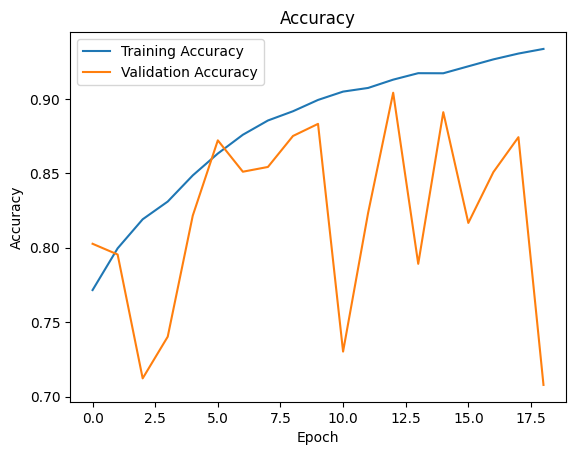

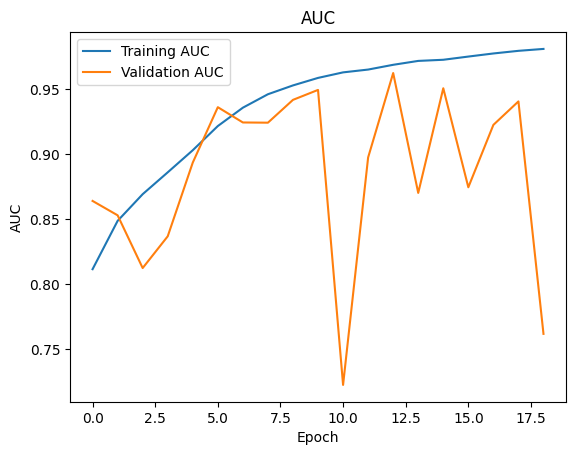

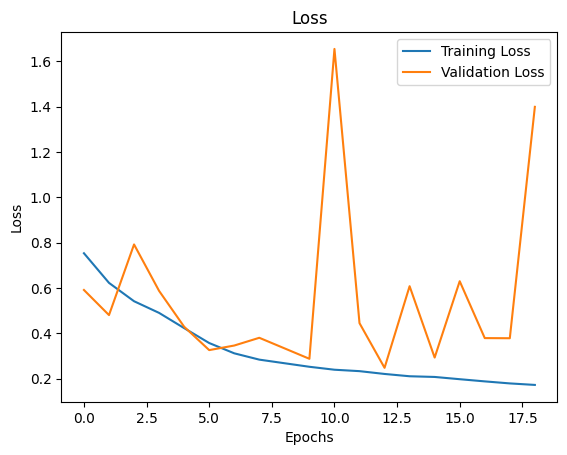

In [15]:
accuracy = epoch_history_es.history['accuracy']
val_accuracy = epoch_history_es.history['val_accuracy']
auc = epoch_history_es.history['auc']
val_auc = epoch_history_es.history['val_auc']
loss = epoch_history_es.history['loss']
val_loss = epoch_history_es.history['val_loss']
epochs_range = range(len(accuracy))

plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(epochs_range, auc, label = 'Training AUC')
plt.plot(epochs_range, val_auc, label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC')
plt.show()

plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [16]:
model_es.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │          25,602 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,344 (1.37 MB)

 Trainable params: 119,298 (466.01 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 238,598 (932.03 KB)

## Running the Kaggle Test Set
The model with more epochs and early stopping performed a lot better across accuracy, AUC, and loss, so I'll use that one for the submission. I'll load the test images, then predict the classification using this model, and finally submit the results to Kaggle.

In [17]:
filenames = os.listdir('//kaggle/input/histopathologic-cancer-detection/test/')
images = [mpimg.imread('//kaggle/input/histopathologic-cancer-detection/test/' + filename) for filename in filenames]

ids = [filename.replace('.tif', '') for filename in filenames]

df_submission = pd.DataFrame({'id': ids, 'img': images})

In [19]:
x_submission = np.asarray(df_submission["img"])

x_submission = np.array([np.array(val) for val in x_submission])
x_submission = np.expand_dims(x_submission, -1)

y_submission = model_es.predict(x_submission)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 164s 91ms/step


In [20]:
print(y_submission)

# Whichever label is larger is the label to use
y_labels = []
for y in y_submission:
    if y[0] > y[1]:
        y_labels.append(0)
    else:
        y_labels.append(1)

df_final = pd.DataFrame({'id': ids, 'label': y_labels})
print(df_final.head())

df_final.to_csv('submission.csv', index=False)

[[0.5064473  0.5357121 ]
 [0.72973067 0.23882246]
 [0.57778925 0.4512541 ]
 ...
 [0.3555849  0.6492186 ]
 [0.9399275  0.07313706]
 [0.9017681  0.09340023]]
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


## Conclusion
The additional epochs on the 2nd model really helped to increase its robustness, and the early stopping prevented it from running additional epochs that didn't improve the model. I'd like to run the model with the full training dataset, which would improve it even more, however the resource constraints are too high. If I had a more efficient way to load the images, I think that would help.